In [2]:
ROOT_DIR = "/home/user/Documents/projects/Metaworld"
%env MUJOCO_GL=egl


import sys
sys.path.append(ROOT_DIR)

import os
import functools
import json
from tqdm import tqdm
import importlib

# scientific
import cv2
import numpy as np

# gym
# from gym.spaces import Box
import mujoco
import metaworld
from metaworld import MT1

# plotting
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from lightglue import viz2d

# project imports
# from metaworld.envs.mujoco.sawyer_xyz.test_scripted_policies import ALL_ENVS, test_cases_latest_nonoise
# import reset_space
import utils.camera_utils_v2 as cu
import keyframes.env_utils as env_utils
import keyframes.env_renderer as env_renderer
import keyframes.mujoco_utils as mujoco_utils
import keyframes.keyframe_utils as keyframe_utils

env: MUJOCO_GL=egl


In [3]:
importlib.reload(keyframe_utils)
importlib.reload(cu)

<module 'utils.camera_utils_v2' from '/home/user/Documents/projects/Metaworld/utils/camera_utils_v2.py'>

## Generate Keyframes

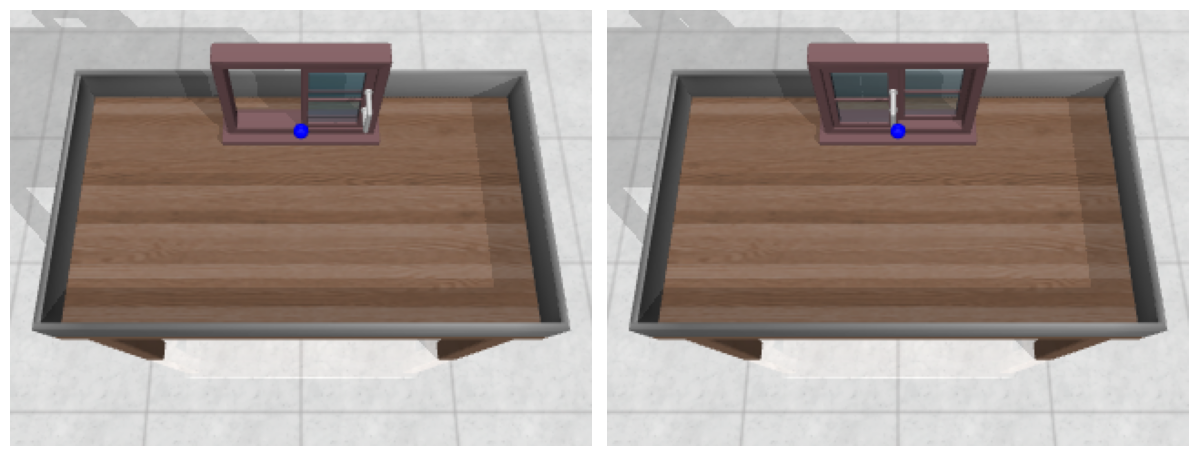

In [4]:
env, expert_policy, renderer = env_utils.generate_env_and_renderer(49)
keyframe_data = keyframe_utils.generate_keyframes(env, renderer)
viz2d.plot_images([keyframe_data["img"][i] for i in range(keyframe_data["img"].shape[0])])
# viz2d.plot_images([env_renderer.process_seg_data(keyframe_data["seg"][i]) for i in range(keyframe_data["img"].shape[0])])

## Visualize Depth Maps

In [5]:
k = 0
real_depth = np.array(keyframe_data["depth"][k])

In [6]:
T_world2pixel = cu.get_camera_transform_matrix(env, "keyframes", *keyframe_data["depth"][k].shape[:2])
T_pixel2world = np.linalg.inv(T_world2pixel)

In [7]:
from scipy.interpolate import RegularGridInterpolator


def pixel_coords_to_world_coords(T_pixel2world, real_depth, pixel_coords_xy = None):
    """
    Convert image coordinates to world coordinates.

    Parameters:
    - T_pixel2world
    - real_depth: np.ndarray with shape (h, w), representing the depth map.
    - pixel_coords_xy: np.ndarray with shape (n, 2), representing the n image coordinates.
    """

    if pixel_coords_xy is None:
        x = np.linspace(0, real_depth.shape[0] - 1, real_depth.shape[0])
        y = np.linspace(0, real_depth.shape[1] - 1, real_depth.shape[1])
        pixel_coords_xy = np.vstack(np.meshgrid(y, x)).reshape(2, -1).T

    x = np.linspace(0, real_depth.shape[0] - 1, real_depth.shape[0])
    y = np.linspace(0, real_depth.shape[1] - 1, real_depth.shape[1])
    # TODO instead of interpolation find minimum across neighours
    # Or Alternatively take 
    interp_depth = RegularGridInterpolator((x, y), real_depth, bounds_error=False, fill_value=100000)

    pixel_coords_xy_center = np.floor(pixel_coords_xy)
    offsets = np.array([[0,0], [0,1], [1,0], [1,1], [-1,0], [0,-1], [-1,-1], [1,-1], [-1,1]])
    pixel_coords_xy_region = pixel_coords_xy_center[:, np.newaxis, :] + offsets[np.newaxis, :, :] # shape (n, 9, 2)

    pixel_z_coords = np.ones((pixel_coords_xy.shape[0], 1), dtype=np.float32) * 100000
    for i in range(9):
        pixel_z_coords_i = interp_depth(pixel_coords_xy_region[:, i, :] @ np.array([[0, 1], [1, 0]]))[:, np.newaxis]  # shape (n, 1)
        # take min depth across all 9 neighbours
        pixel_z_coords = np.minimum(pixel_z_coords, pixel_z_coords_i)  # shape (n, 1)
    # pixel_z_coords /= 9.0

    # pixel_z_coords = interp_depth(pixel_coords_xy @ np.array([[0, 1], [1, 0]]))[:, np.newaxis]  # shape (n, 1)

    pixel_coords = np.hstack((pixel_coords_xy * pixel_z_coords, pixel_z_coords, np.ones_like(pixel_z_coords)))
    world_coords = (T_pixel2world @ pixel_coords.T).T
    
    return world_coords, pixel_coords

In [8]:
world_coords, pixel_coords = pixel_coords_to_world_coords(T_pixel2world, real_depth)
world_coords.shape

(76800, 4)

In [9]:
k = 0
pts = world_coords.T
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=pts[0],
            y=pts[1],
            z=pts[2],
            mode="markers",
            marker=dict(
                size=1,
                # color=xy_c0[2],                # set color to an array/list of desired values
                colorscale="Viridis",  # choose a colorscale
                opacity=0.8,
            ),
        )
    ]
)

geom_pts = keyframe_data["geom_xpos"][k]
fig.add_scatter3d(
    x=geom_pts[:, 0],
    y=geom_pts[:, 1],
    z=geom_pts[:, 2],
    mode="markers",
    marker=dict(
        size=2,
        # color=xy_c0[2],                # set color to an array/list of desired values
        color="red",  # choose a colorscale
        opacity=1,
    ),
)
# fig.add_scatter3d(x=[end_effector_pos[0]], y=[end_effector_pos[1]], z=[end_effector_pos[2]], mode='markers', marker=dict(
#     size=1,
#     color="red"
# ))
fig.update_layout(
    autosize=True,
    width=800,
    height=600,
    # scene_aspectmode='cube'
)

In [67]:
env.model.body("window").pos

array([0.        , 0.77124721, 0.2       ])